In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from drail.learn.local_learner import LocalLearner
from mf_features import MoralFoundationFE
from mf_scoring import MoralFoundationSC
import json
import torch
import os

#torch.cuda.set_device(1)

DATA_PATH = '/scratch/pachecog/data_processing_SHAMIK/drail_data_abortion'

In [2]:
learner = LocalLearner(infer_algorithm='AD3')
#learner.set_savedir("local_shamik")

In [3]:
learner.build_parser()

In [4]:
learner.define_entity("Event")
learner.define_entity("Tweet")
learner.define_entity("Entity")
learner.define_entity("Role")
learner.define_entity("MoralFoundation")
learner.define_entity("Topic")
learner.define_entity("Ideology")
learner.define_entity("EntityGroup")
learner.define_entity("Polarity")

In [5]:
learner.define_label("RoleLabel", n_classes=16, data_file="role.txt")
learner.define_label("MfLabel", n_classes=5, data_file="mf.txt")
learner.define_label("ConceptLabel", n_classes=2, data_file="yesno.txt")

In [6]:
learner.define_predicate("InInstance", entities=["Tweet", "Event"], data_file="in_instance.txt")
learner.define_predicate("HasEntity", entities=["Tweet", "Entity"], data_file="has_entity.txt")
learner.define_predicate("HasRole", entities=["Tweet", "Entity", "Role"], data_file="has_role.txt")
learner.define_predicate("HasMf", entities=["Tweet", "MoralFoundation"], data_file="has_mf.txt")
learner.define_predicate("RoleHasMf", entities=["Role", "MoralFoundation"], data_file="role_has_mf.txt")
learner.define_predicate("HasTopic", entities=["Tweet", "Topic"], data_file="has_topic.txt")
learner.define_predicate("HasIdeology", entities=["Tweet", "Ideology"], data_file="has_ideology.txt")
learner.define_predicate("HasEntityGroup", entities=["Entity", "EntityGroup"], data_file="has_entity_group_name.txt")
learner.define_predicate("RoleHasPolarity", entities=["Role", "Polarity"], data_file="role_has_polarity.txt")

db = learner.create_dataset(DATA_PATH)

I0820 03:51:05.216861 140092913002304 learner.py:166] self.par.files={'RoleLabel': 'role.txt', 'MfLabel': 'mf.txt', 'ConceptLabel': 'yesno.txt', 'InInstance': 'in_instance.txt', 'HasEntity': 'has_entity.txt', 'HasRole': 'has_role.txt', 'HasMf': 'has_mf.txt', 'RoleHasMf': 'role_has_mf.txt', 'HasTopic': 'has_topic.txt', 'HasIdeology': 'has_ideology.txt', 'HasEntityGroup': 'has_entity_group_name.txt', 'RoleHasPolarity': 'role_has_polarity.txt'}
I0820 03:51:05.217958 140092913002304 database_new.py:56] CREATE TABLE InInstance (TweetId_1 TEXT, EventId_2 TEXT)
I0820 03:51:05.330055 140092913002304 database_new.py:56] CREATE TABLE HasEntity (TweetId_1 TEXT, EntityId_2 TEXT)
I0820 03:51:05.655733 140092913002304 database_new.py:56] CREATE TABLE HasRole (TweetId_1 TEXT, EntityId_2 TEXT, RoleId_3 TEXT)
I0820 03:51:06.048295 140092913002304 database_new.py:56] CREATE TABLE HasMf (TweetId_1 TEXT, MoralFoundationId_2 TEXT)
I0820 03:51:06.160861 140092913002304 database_new.py:56] CREATE TABLE RoleH

In [7]:
learner.fe = MoralFoundationFE(data_path=DATA_PATH)
learner.sc = MoralFoundationSC(data_path=DATA_PATH)

In [8]:
learner.define_manual_rule(
    "InInstance(T, Z) & HasEntity(T, E) => HasRole(T, E, R^RoleLabel?)",
    lmd=1.0,
    scoring_function="pretrained_score",
    features=["rule_key"]
)

learner.define_manual_rule(
    "InInstance(T, Z) => HasMf(T, M^MfLabel?)",
    lmd=1.0,
    scoring_function="pretrained_score",
    features=["rule_key"]
)

learner.define_manual_rule(
    "InInstance(T, Z) & HasIdeology(T, I) & HasTopic(T, S) => HasMf(T, M^MfLabel?)",
    lmd=1.0,
    scoring_function="pretrained_score",
    features=["rule_key"]
)

learner.define_manual_rule(
    "InInstance(T, Z) & HasEntity(T, E) & HasIdeology(T, I) & HasTopic(T, S) => HasRole(T, E, R^RoleLabel?)",
    lmd=1.0,
    scoring_function="pretrained_score",
    features=["rule_key"]
)

learner.define_hardconstr(
    "InInstance(T, Z) & HasEntity(T, E) & RoleHasMf(R, M) & HasRole(T, E, R)^? => HasMf(T, M)^?"
)

learner.define_scope(pred_name="InInstance", entity_name="Event")
learner.build_models(db, {}, isdic=True)

I0820 03:51:07.248908 140092913002304 learner.py:417] InInstance(T,Z) & HasEntity(T,E) => HasRole(T,E,R^RoleLabel-Multiclass-16)
I0820 03:51:07.249520 140092913002304 learner.py:417] InInstance(T,Z) => HasMf(T,M^MfLabel-Multiclass-5)
I0820 03:51:07.250024 140092913002304 learner.py:417] InInstance(T,Z) & HasIdeology(T,I) & HasTopic(T,S) => HasMf(T,M^MfLabel-Multiclass-5)
I0820 03:51:07.250478 140092913002304 learner.py:417] InInstance(T,Z) & HasEntity(T,E) & HasIdeology(T,I) & HasTopic(T,S) => HasRole(T,E,R^RoleLabel-Multiclass-16)


In [9]:
import random

tweets = [x.split('\t')[0] for x in open(os.path.join(DATA_PATH, "in_instance.txt")).readlines()]
random.shuffle(tweets)
tweets = tweets[:1000]

db.add_filters(filters=[
    ("InInstance", "isTest", "TweetId_1", tweets)]
)

In [10]:
learner.build_feature_extractors(db, filters=[("InInstance", "isDummy", 1)])

In [11]:
learner.extract_instances(db, extract_test=True, test_filters=[("InInstance", "isTest", 1)])
res, heads = learner.predict(db, fold_filters=[("InInstance", "isTest", 1)], fold='test', get_predicates=True)

I0820 03:51:07.488234 140092913002304 local_learner.py:297] predicting...
100%|██████████| 1000/1000 [00:15<00:00, 64.94it/s]


In [12]:
from mf_eval_utils import MFEvaluation

evaluation = MFEvaluation(heads, DATA_PATH)

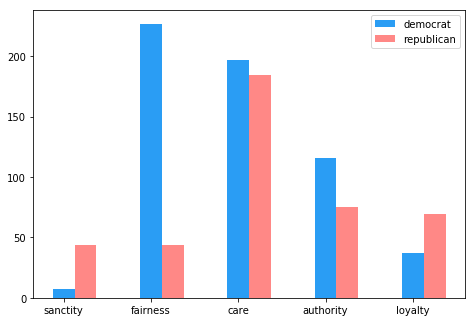

In [13]:
evaluation.mf_graph()

In [14]:
evaluation.top_k_entities(ideology='right')

[(('life', 'target-care-harm'), 84),
 (('abortion', 'cause-harm'), 66),
 (('life', 'target-loyal-betray'), 48),
 (('babies', 'target-care-harm'), 30),
 (('life', 'target-purity-degrad'), 21)]

In [15]:
evaluation.top_k_entities(ideology='left')

[(('women', 'target-fair-cheat'), 156),
 (('women', 'target-care-harm'), 103),
 (('reproductive rights', 'target-fair-cheat'), 61),
 (('abortion', 'cause-harm'), 47),
 (('abortion', 'do-cheat'), 45)]

In [16]:
evaluation.get_frequent_entities(k=20)

[('women', 325),
 ('abortion', 235),
 ('life', 207),
 ('wade', 115),
 ('trump', 111),
 ('roe', 104),
 ('planned parenthood', 91),
 ('reproductive rights', 90),
 ('health care', 62),
 ('unborn', 56),
 ('p pfa', 50),
 ('supreme court', 47),
 ('gag rule', 47),
 ('democrats', 44),
 ('roe v wade', 44),
 ('reproductive health care', 38),
 ('scotus', 38),
 ('title x', 37),
 ('pp', 36),
 ('babies', 36)]

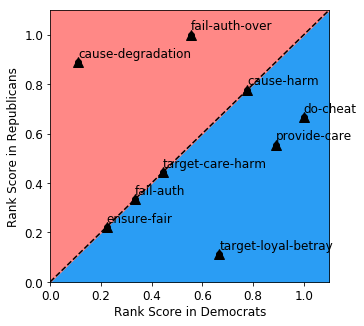

In [17]:
evaluation.role_polarity_graph(entity='planned parenthood')

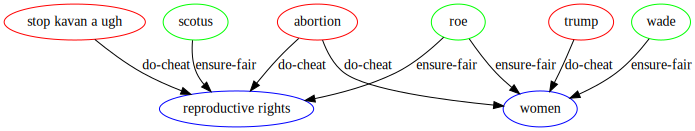

In [18]:
evaluation.entity_graph(ideology='left', mf='fairness')

In [19]:
evaluation.show_examples_entity_pair(ideology='left', entity_1='abortion', entity_role_1='do-cheat', 
                                     entity_2='women', entity_role_2='target-fair-cheat', k=5)

Total found: 21. Showing: 5
('1235261961300062210', 'the case before the supreme court today is about restricting our constitutional right to abortion not protecting women i ll keep fighting to ensure that every virginian has access to quality reproductive care my right my decision')

('1016775852217044992', 'president trump has said that women should face punishment for exercising their constitutional right to abortion now with brett kavan a ugh s nomination this nightmare could become a reality we must stop kavan a ugh and protect women s right to choose')

('1132644002270982145', 'reproductive rights are women s rights are human rights proud of seattle for standing strong to protest bigoted and unconstitutional bans on abortion')

('1126550866931195905', 'women should be trusted to make their own medical decisions including abortion without interference from politicians full stop')

('956004127565164544', 'when doctors take the oath to do no harm that includes not using religion to 

In [20]:
learner.define_manual_rule(
    'InInstance(T, Z) & HasIdeology(T, "left") & HasEntity(T, E) & HasEntityGroup(E, "abortion") & RoleHasPolarity(R, "negative") => ~HasRole(T, E, R)^?',
    lmd="10.0",
    scoring_function="bias_neg",
    features=["bias"]
)
learner.build_models(db, {}, isdic=True)

I0820 03:51:23.679965 140092913002304 learner.py:417] InInstance(T,Z) & HasEntity(T,E) => HasRole(T,E,R^RoleLabel-Multiclass-16)
I0820 03:51:23.680641 140092913002304 learner.py:417] InInstance(T,Z) => HasMf(T,M^MfLabel-Multiclass-5)
I0820 03:51:23.681038 140092913002304 learner.py:417] InInstance(T,Z) & HasIdeology(T,I) & HasTopic(T,S) => HasMf(T,M^MfLabel-Multiclass-5)
I0820 03:51:23.681420 140092913002304 learner.py:417] InInstance(T,Z) & HasEntity(T,E) & HasIdeology(T,I) & HasTopic(T,S) => HasRole(T,E,R^RoleLabel-Multiclass-16)
I0820 03:51:23.681774 140092913002304 learner.py:417] InInstance(T,Z) & HasIdeology(T,"left") & HasEntity(T,E) & HasEntityGroup(E,"abortion") & RoleHasPolarity(R,"negative") => ~HasRole(T,E,R)^?


In [21]:
learner.extract_instances(db, extract_test=True, test_filters=[("InInstance", "isTest", 1)])
res, heads = learner.predict(db, fold_filters=[("InInstance", "isTest", 1)], fold='test', get_predicates=True, scmodule_path=".")
evaluation.update_predictions(heads)

I0820 03:51:23.713782 140092913002304 local_learner.py:297] predicting...
100%|██████████| 1000/1000 [00:34<00:00, 29.06it/s]


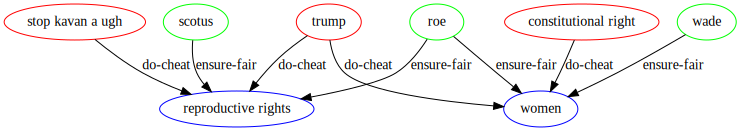

In [22]:
evaluation.entity_graph(ideology='left', mf='fairness')

In [23]:
evaluation.show_examples_entity_pair(ideology='left', entity_1='abortion', entity_role_1='do-cheat', 
                                     entity_2='women', entity_role_2='target-fair-cheat', k=5)

Total found: 4. Showing: 4
('1016775852217044992', 'president trump has said that women should face punishment for exercising their constitutional right to abortion now with brett kavan a ugh s nomination this nightmare could become a reality we must stop kavan a ugh and protect women s right to choose')

('1224904230286372864', 'women and men nationwide overwhelmingly do not want to go back to the days before women had a constitutional right to abortion protect roe so tu')

('1016668571483729920', 'abortion should be a choice made by a woman and her doctor not these two guys')

('1130937020442906625', 'state abortion bans are a systematic effort by republicans to restrict women s reproductive rights and overturn roe v wade women should have the last word when it comes to their own bodies their own lives and their own pregnancies stop thebans')



In [24]:
concepts = {
    "AbortionRights": "abortion is a constitutional right",
}

learner.define_entity("Concept", support=concepts)
learner.define_latent_predicate("MentionsConcept", ["Tweet", "Concept"])

In [25]:
learner.define_manual_rule(
    'InInstance(T, Z) & HasIdeology(T, "left") => MentionsConcept(T, "AbortionRights", Y^ConceptLabel?)',
    lmd=10.0,
    scoring_function="cosine",
    features=["tweet_concept_cosine_dist"]
)

learner.define_hardconstr(
    'InInstance(T, Z) & HasIdeology(T, "left") & HasEntity(T, E) & HasEntityGroup(E, "abortion") & RoleHasPolarity(R, "negative") & MentionsConcept(T, "AbortionRights", "yes")^? => ~HasRole(T, E, R)^?'
)

learner.build_models(db, {}, isdic=True)

I0820 03:51:58.318314 140092913002304 learner.py:417] InInstance(T,Z) & HasEntity(T,E) => HasRole(T,E,R^RoleLabel-Multiclass-16)
I0820 03:51:58.319397 140092913002304 learner.py:417] InInstance(T,Z) => HasMf(T,M^MfLabel-Multiclass-5)
I0820 03:51:58.320198 140092913002304 learner.py:417] InInstance(T,Z) & HasIdeology(T,I) & HasTopic(T,S) => HasMf(T,M^MfLabel-Multiclass-5)
I0820 03:51:58.320611 140092913002304 learner.py:417] InInstance(T,Z) & HasEntity(T,E) & HasIdeology(T,I) & HasTopic(T,S) => HasRole(T,E,R^RoleLabel-Multiclass-16)
I0820 03:51:58.321064 140092913002304 learner.py:417] InInstance(T,Z) & HasIdeology(T,"left") & HasEntity(T,E) & HasEntityGroup(E,"abortion") & RoleHasPolarity(R,"negative") => ~HasRole(T,E,R)^?
I0820 03:51:58.321530 140092913002304 learner.py:417] InInstance(T,Z) & HasIdeology(T,"left") => MentionsConcept(T,"AbortionRights",Y^ConceptLabel-Multiclass-2)


In [26]:
learner.extract_instances(db, extract_test=True, test_filters=[("InInstance", "isTest", 1)])
res, heads = learner.predict(db, fold_filters=[("InInstance", "isTest", 1)], fold='test', get_predicates=True)
evaluation.update_predictions(heads)

I0820 03:51:58.354477 140092913002304 local_learner.py:297] predicting...
100%|██████████| 1000/1000 [00:50<00:00, 19.76it/s]


In [27]:
evaluation.show_examples_entity_pair(ideology='left', entity_1='abortion', entity_role_1='do-cheat', 
                                     entity_2='women', entity_role_2='target-fair-cheat', k=5)

Total found: 2. Showing: 2
('1016668571483729920', 'abortion should be a choice made by a woman and her doctor not these two guys')

('1130937020442906625', 'state abortion bans are a systematic effort by republicans to restrict women s reproductive rights and overturn roe v wade women should have the last word when it comes to their own bodies their own lives and their own pregnancies stop thebans')



In [28]:
evaluation.show_tweets_where_concept(concept='AbortionRights', k=5)

Total found: 17. Showing: 5
('1277616712301580288', 'breaking news supreme court overturns louisiana anti abortion law determines law imposes an undue burden on a woman s constitutional right to choose to have an abortion big victory for women and choice')

('1016775852217044992', 'president trump has said that women should face punishment for exercising their constitutional right to abortion now with brett kavan a ugh s nomination this nightmare could become a reality we must stop kavan a ugh and protect women s right to choose')

('1133893284575830016', 'reproductive health is a basic human right and a cornerstone of women s rights i applaud nevada ag s decision to take part in a court case to defend access to reproductive care')

('907000230532579328', 'kentucky s efforts to close their last abortion clinic is a blatant attack on women s rights')

('1235261961300062210', 'the case before the supreme court today is about restricting our constitutional right to abortion not protecting

In [29]:
evaluation.top_k_entities(ideology='left')

[(('women', 'target-fair-cheat'), 155),
 (('women', 'target-care-harm'), 101),
 (('reproductive rights', 'target-fair-cheat'), 61),
 (('wade', 'ensure-fair'), 42),
 (('roe', 'ensure-fair'), 31)]

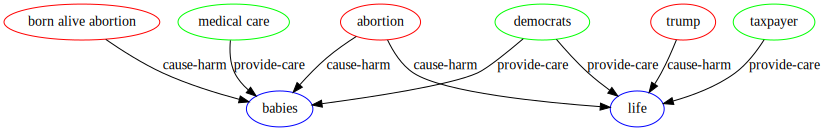

In [30]:
evaluation.entity_graph(ideology='right', mf='care')

In [31]:
evaluation.show_examples_entity_pair(ideology='right', entity_1='democrats', entity_role_1='provide-care', 
                                     entity_2='babies', entity_role_2='target-care-harm', k=5)

Total found: 5. Showing: 5
('1100387800438972418', 'last night with a number of my colleagues i urged the senate to protect newborn babies unfortunately democrats made clear their willingness to allow babies to die after being born alive a sad day for our nation pro life born alive')

('958412117958365185', 'yesterday senate democrats continued their tradition of neglecting moral responsibility and blocked legislation that would put an end to abortions of babies older than five months and provide protections for unborn children capable of feeling pain')

('1233078128999829504', 'i am disappointed senate democrats blocked a bill that provides medical attention for babies who survive abortions even 77 of pro choice voters agree with this basic concept babies born alive deserve medical care')

('1141393711038947328', 'today i requested unanimous consent for the born alive abortion survivors protection act sadly democrats once again refused to consider a bill that would require physicians 

In [32]:
# separate in dems block legislation + legislation about babies/life/pro-life 
concepts["DemsBlockBill"] = "democrats refuse and vote against"
concepts["BabiesProtectionAct"] = "protection for babies born alive during abortions"
learner.define_entity("Concept", support=concepts)

learner.define_manual_rule(
    'InInstance(T, Z) & HasIdeology(T, "right") => MentionsConcept(T, "DemsBlockBill", Y^ConceptLabel?)',
    lmd=1.0,
    scoring_function="cosine",
    features=["tweet_concept_cosine_dist"]
)

learner.define_manual_rule(
    'InInstance(T, Z) & HasIdeology(T, "right") => MentionsConcept(T, "BabiesProtectionAct", Y^ConceptLabel?)',
    lmd=1.0,
    scoring_function="cosine",
    features=["tweet_concept_cosine_dist"]
)

learner.define_hardconstr(
    'InInstance(T, Z) & HasIdeology(T, "right") & HasEntity(T, E) & HasEntityGroup(E, "democrats")' +
    ' & RoleHasPolarity(R, "positive") & MentionsConcept(T, "DemsBlockBill", "yes")^?' +
    ' & MentionsConcept(T, "BabiesProtectionAct", "yes")^? => ~HasRole(T, E, R)^?'
)

learner.build_models(db, {}, isdic=True)

I0820 03:52:50.570636 140092913002304 learner.py:417] InInstance(T,Z) & HasEntity(T,E) => HasRole(T,E,R^RoleLabel-Multiclass-16)
I0820 03:52:50.571256 140092913002304 learner.py:417] InInstance(T,Z) => HasMf(T,M^MfLabel-Multiclass-5)
I0820 03:52:50.571854 140092913002304 learner.py:417] InInstance(T,Z) & HasIdeology(T,I) & HasTopic(T,S) => HasMf(T,M^MfLabel-Multiclass-5)
I0820 03:52:50.572299 140092913002304 learner.py:417] InInstance(T,Z) & HasEntity(T,E) & HasIdeology(T,I) & HasTopic(T,S) => HasRole(T,E,R^RoleLabel-Multiclass-16)
I0820 03:52:50.572790 140092913002304 learner.py:417] InInstance(T,Z) & HasIdeology(T,"left") & HasEntity(T,E) & HasEntityGroup(E,"abortion") & RoleHasPolarity(R,"negative") => ~HasRole(T,E,R)^?
I0820 03:52:50.573283 140092913002304 learner.py:417] InInstance(T,Z) & HasIdeology(T,"left") => MentionsConcept(T,"AbortionRights",Y^ConceptLabel-Multiclass-2)
I0820 03:52:50.573663 140092913002304 learner.py:417] InInstance(T,Z) & HasIdeology(T,"right") => Mentions

In [33]:
learner.extract_instances(db, extract_test=True, test_filters=[("InInstance", "isTest", 1)])
res, heads = learner.predict(db, fold_filters=[("InInstance", "isTest", 1)], fold='test', get_predicates=True)
evaluation.update_predictions(heads)

I0820 03:52:50.605637 140092913002304 local_learner.py:297] predicting...
100%|██████████| 1000/1000 [01:08<00:00, 14.65it/s]


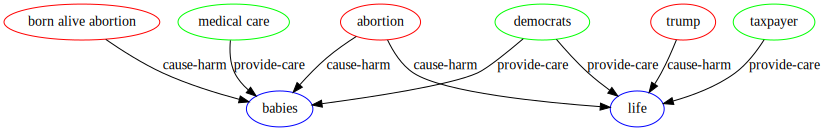

In [35]:
evaluation.entity_graph(ideology='right', mf='care')

In [34]:
evaluation.show_examples_entity_pair(ideology='right', entity_1='democrats', entity_role_1='provide-care', 
                                     entity_2='babies', entity_role_2='target-care-harm', k=5)

Total found: 5. Showing: 5
('1100387800438972418', 'last night with a number of my colleagues i urged the senate to protect newborn babies unfortunately democrats made clear their willingness to allow babies to die after being born alive a sad day for our nation pro life born alive')

('958412117958365185', 'yesterday senate democrats continued their tradition of neglecting moral responsibility and blocked legislation that would put an end to abortions of babies older than five months and provide protections for unborn children capable of feeling pain')

('1233078128999829504', 'i am disappointed senate democrats blocked a bill that provides medical attention for babies who survive abortions even 77 of pro choice voters agree with this basic concept babies born alive deserve medical care')

('1141393711038947328', 'today i requested unanimous consent for the born alive abortion survivors protection act sadly democrats once again refused to consider a bill that would require physicians 

In [37]:
evaluation.show_tweets_where_concept(concept='BabiesProtectionAct', k=10)

Total found: 6. Showing: 6
('1141393711038947328', 'today i requested unanimous consent for the born alive abortion survivors protection act sadly democrats once again refused to consider a bill that would require physicians to give lifesaving medical care to babies that survive an abortion')

('1220021643025752071', 'protecting the unborn is a key priority this year we ve stood up for babies that are born alive with the born alive act and successfully pushed to get rid of the hidden abortion tax in obama care pro life')

('1106225881213743104', 'today i asked for unanimous consent for the house to consider the born alive abortion survivors protection act for the 19 th time house democrats rejected our call to save children born alive')

('1113099996474347522', 'currently doctors in 24 states can leave a child born alive during an abortion to die and not face criminal charges this is deplorable it is time we get our legislators on record to end infanticide across all 50 states')

('110

In [38]:
evaluation.show_tweets_where_concept(concept='DemsBlockBill', k=10)

Total found: 0. Showing: 0
